In [78]:
#LIBRARIES 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score as evs

import datetime as dt

import statsmodels.api as sm

In [79]:
#READING CSV
#Reservoir information
resnov=pd.read_csv('guj_nov.csv')
resdec=pd.read_csv('guj_dec.csv')
resjan=pd.read_csv('guj_jan.csv')
resfeb=pd.read_csv('guj_feb.csv')
resmarch=pd.read_csv('guj_march.csv')

#Rainfall information
rainnov=pd.read_csv('gujrain_nov.csv')
raindec=pd.read_csv('gujrain_dec.csv')
rainjan=pd.read_csv('gujrain_jan.csv')
rainfeb=pd.read_csv('gujrain_feb.csv')
rainmarch=pd.read_csv('gujrain_march.csv')

#Evapo-transpiration rate information
evap=pd.read_csv('evapnovmarch.csv')



In [80]:
#MERGING CSVS TO CREATE ONE DATASET

#Cumulative reservoir level data
merge1=pd.concat([resnov,resdec],axis=0)
merge1=pd.concat([merge1,resjan],axis=0)
merge1=pd.concat([merge1,resfeb],axis=0)
merge1=pd.concat([merge1,resmarch],axis=0).drop(['Agency_name'],axis=1)

#Cumulative rainfall level 
merge2=pd.concat([rainnov,raindec],axis=0)
merge2=pd.concat([merge2,rainjan],axis=0)
merge2=pd.concat([merge2,rainfeb],axis=0)
merge2=pd.concat([merge2,rainmarch],axis=0).drop(['Agency_name'],axis=1)



In [81]:
#dropping null values
merge1=merge1.dropna()
merge2=merge2.dropna()




In [82]:
#creating master file for all three dataset
mergeboth=pd.merge(merge1,merge2,on=['Basin','Subbasin','Date','Month','Year'])
mergeall=pd.merge(mergeboth,evap,on=['Basin','Date','Year'])
mergeall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8830 entries, 0 to 8829
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Reservoir_name           8830 non-null   object 
 1   Basin                    8830 non-null   object 
 2   Subbasin                 8830 non-null   object 
 3   Date                     8830 non-null   object 
 4   Year                     8830 non-null   int64  
 5   Month                    8830 non-null   int64  
 6   Full_reservoir_level     8830 non-null   float64
 7   Live_capacity_FRL        8830 non-null   float64
 8   Storage                  8830 non-null   float64
 9   Level                    8830 non-null   float64
 10  Avg_rainfall             8830 non-null   float64
 11  Evapotranspiration (mm)  8830 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 896.8+ KB


In [83]:
#converting date into int as well

mergeall['Date'] = pd.to_datetime(mergeall['Date'])
mergeall['Date']=mergeall['Date'].map(dt.datetime.toordinal)

In [84]:
#one hot encoding for Basin
mergeall= pd.get_dummies(mergeall, columns = ['Basin'])


In [85]:
#Label encoding for month
mergeall.Month.unique()


array([11, 12,  1,  2,  3])

In [86]:

le=LabelEncoder()
mergeall['Month']=le.fit_transform(mergeall['Month'])
mergeall.Month.unique()

array([3, 4, 0, 1, 2])

In [87]:
#after converting datatypes
mergeall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8830 entries, 0 to 8829
Data columns (total 17 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   Reservoir_name                                                          8830 non-null   object 
 1   Subbasin                                                                8830 non-null   object 
 2   Date                                                                    8830 non-null   int64  
 3   Year                                                                    8830 non-null   int64  
 4   Month                                                                   8830 non-null   int64  
 5   Full_reservoir_level                                                    8830 non-null   float64
 6   Live_capacity_FRL                                                       8830 non

In [88]:
#Summarising the statistical data
mergeall.describe()

#Now overall there are 6832 records in our master dataset file
#The mean level is 98.1211 while the median is 88.3 thus the data is right skewed.
#The max value is 331 which is far greater than the mean value of Level thus it indicates the presence of outliers.


,Date,Year,Month,Full_reservoir_level,Live_capacity_FRL,Storage,Level,Avg_rainfall,Evapotranspiration (mm),Basin_Mahi Basin,Basin_Narmada Basin,Basin_Sabarmati Basin,Basin_Tapi Basin,Basin_West flowing rivers from Tapi to Tadri Basin,Basin_West flowing rivers of Kutch and Saurashtra including Luni Basin
count,8830.000000,8830.000000,8830.000000,8830.000000,8.830000e+03,8830.000000,8830.000000,8.830000e+03,8830.000000,8830.000000,8830.000000,8830.000000,8830.000000,8830.000000,8830.000000
mean,738547.214609,2022.701925,1.919026,102.073838,9.445725e-03,0.077998,98.432042,2.878567e-01,0.255704,0.078935,0.013250,0.132729,0.049264,0.030917,0.694904
std,38.746289,0.457438,1.431610,62.739529,2.116495e-01,0.558240,62.144510,8.288210e-01,0.244747,0.269653,0.114351,0.339301,0.216431,0.173104,0.460474
min,738460.000000,2022.000000,0.000000,5.640000,1.000000e-08,0.000010,3.080000,7.700000e-09,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,738515.000000,2022.000000,1.000000,50.350000,6.880000e-06,0.002210,47.000000,2.802254e-04,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,738552.000000,2023.000000,2.000000,91.000000,1.205000e-05,0.005605,88.380000,3.017875e-03,0.190000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,738585.000000,2023.000000,3.000000,140.020000,3.681000e-05,0.015095,134.972500,6.916461e-02,0.340000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,738605.000000,2023.000000,4.000000,332.000000,7.414290e+00,7.400050,331.900000,1.003350e+01,2.940000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data visualization


0-> Jan 2023, 1-> March 2023, 2->Nov 2022, 3-> Dec 2022


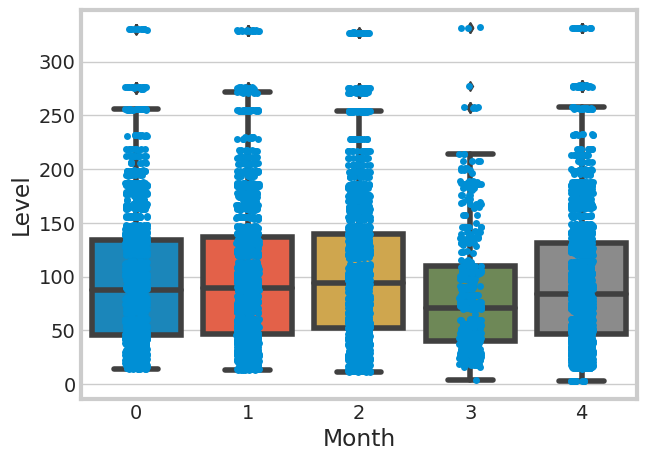

In [89]:
#BOXPLOTS FOR EACH MONTH
sns.set_style('whitegrid')
sns.boxplot(x='Month',y='Level',data=mergeall)
sns.stripplot(x="Month", y="Level",data=mergeall)

print("0-> Jan 2023, 1-> March 2023, 2->Feb 2023, 3-> Nov 2022, 4->Dec 2022")

#Mean level is between 50 and 100 
#Month 3 i.e. November has lowest reservoir levels
#Month 2 i.e. March has highest reservoir levels 
#There are outliers present for each month's data

<Axes: xlabel='Year', ylabel='Level'>

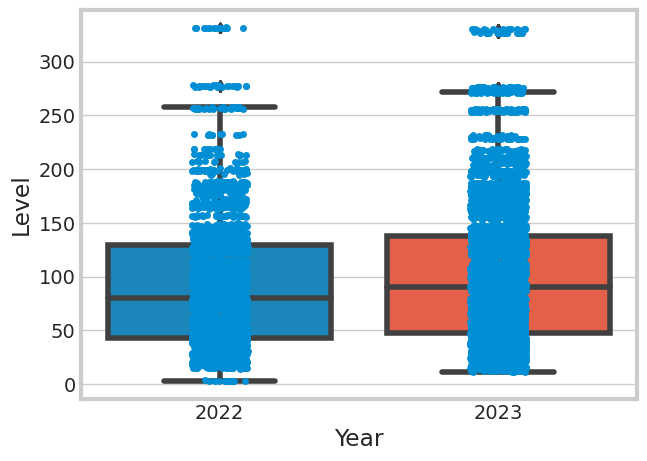

In [90]:
#BOXPLOTS FOR YEAR
sns.set_style('whitegrid')
sns.boxplot(x='Year',y='Level',data=mergeall)
sns.stripplot(x="Year", y="Level",data=mergeall)

#beginning of 2023 has higher mean reservoir level compared to the end of 2022

0-> Jan 2023, 1-> March 2023, 2->Feb 2023, 3-> Nov 2022, 4->Dec 2022


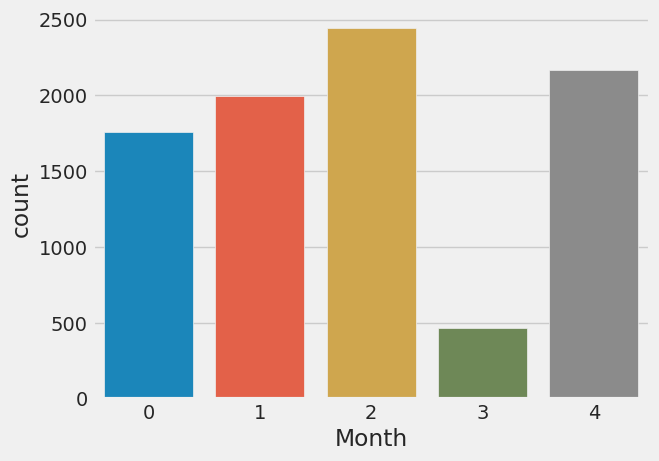

In [112]:
#COUNTPLOTS
sns.countplot(data=mergeall,x='Month')
print("0-> Jan 2023, 1-> March 2023, 2->Feb 2023, 3-> Nov 2022, 4->Dec 2022")
#There are very less datapoints in November, this might affect the distribution of data

<Axes: xlabel='Basin', ylabel='count'>

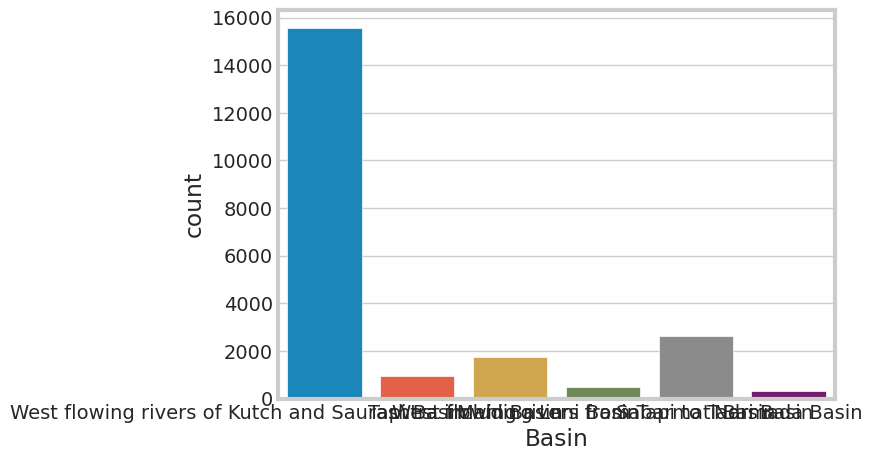

In [92]:
sns.countplot(data=merge1.dropna(),x='Basin')
#There are a large number of datapoints in West flowing rivers of Kutch and Saurashtra, this might affect the distribution of data

<Axes: >

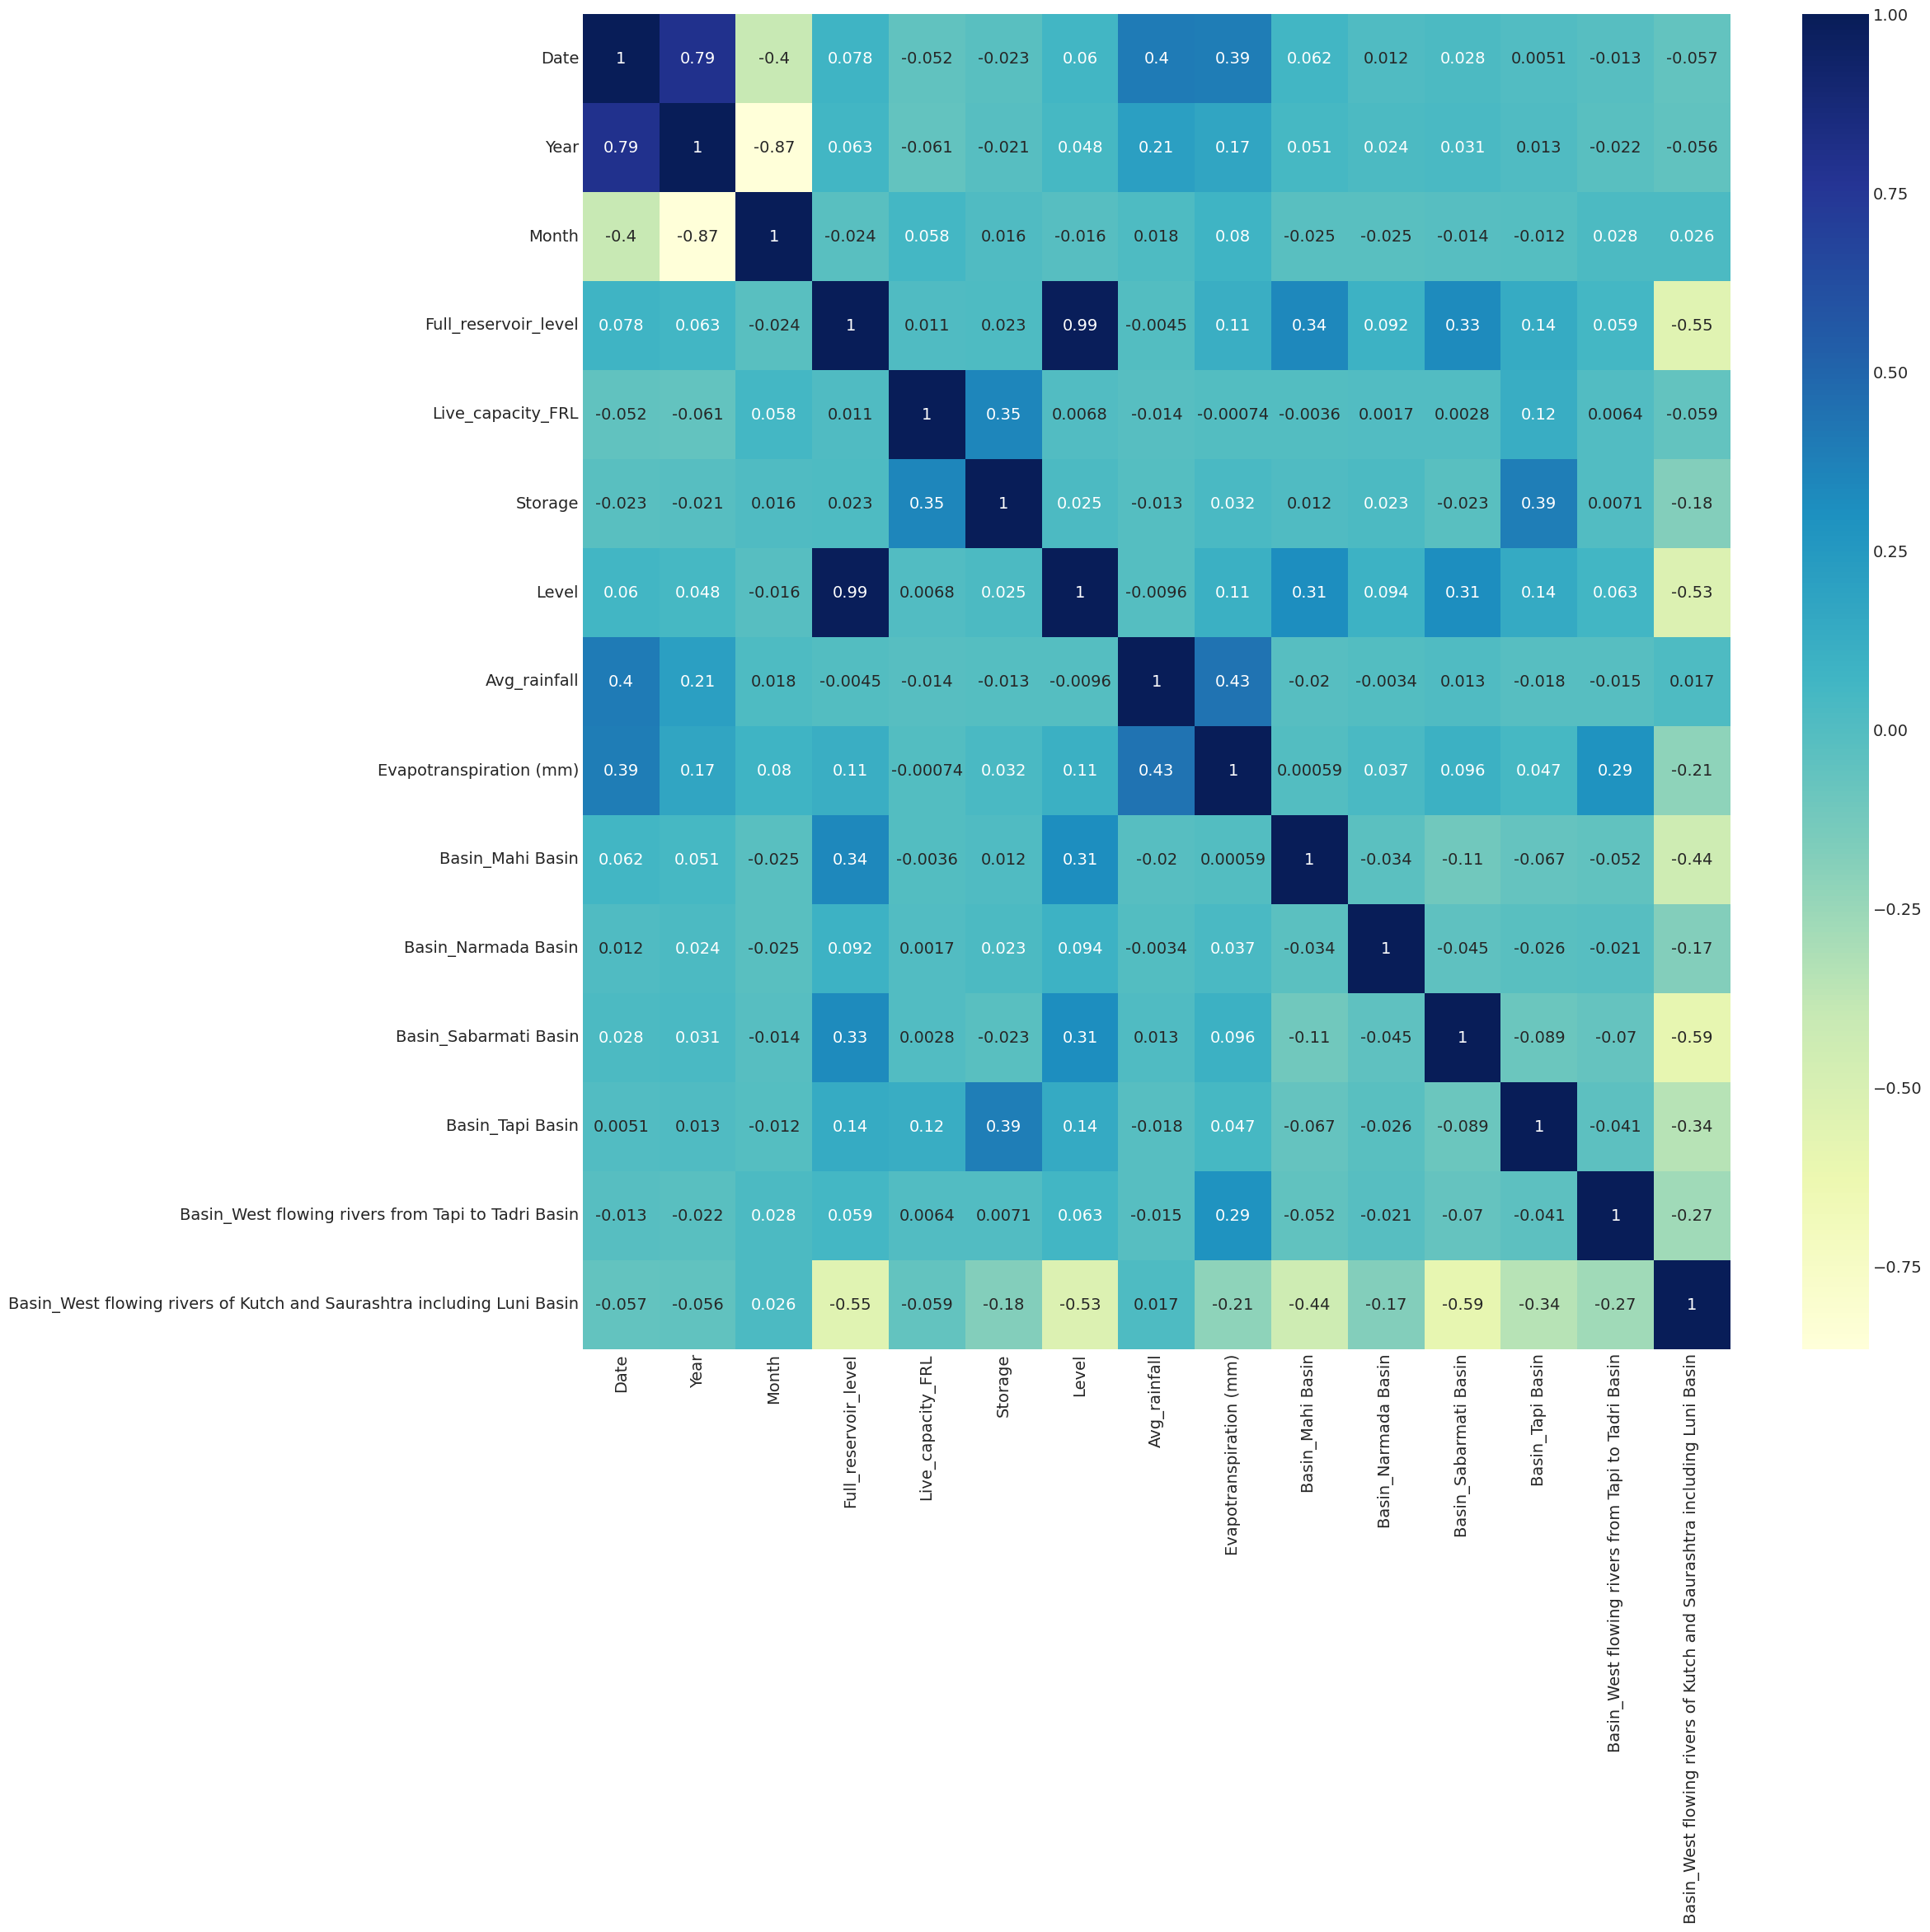

In [93]:
#HEATMAP
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(mergeall.corr(),annot=True, cmap='YlGnBu',ax=ax)

#Considering features which affect level more than 0.05:
#Level is affected significantly by the type of basin, Evapotranspiration (mm), Full_reservoir_level and Date and Year

<ipython-input-94-8389bb67d56e>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.zeros_like(spear,dtype=np.bool)


<Axes: >

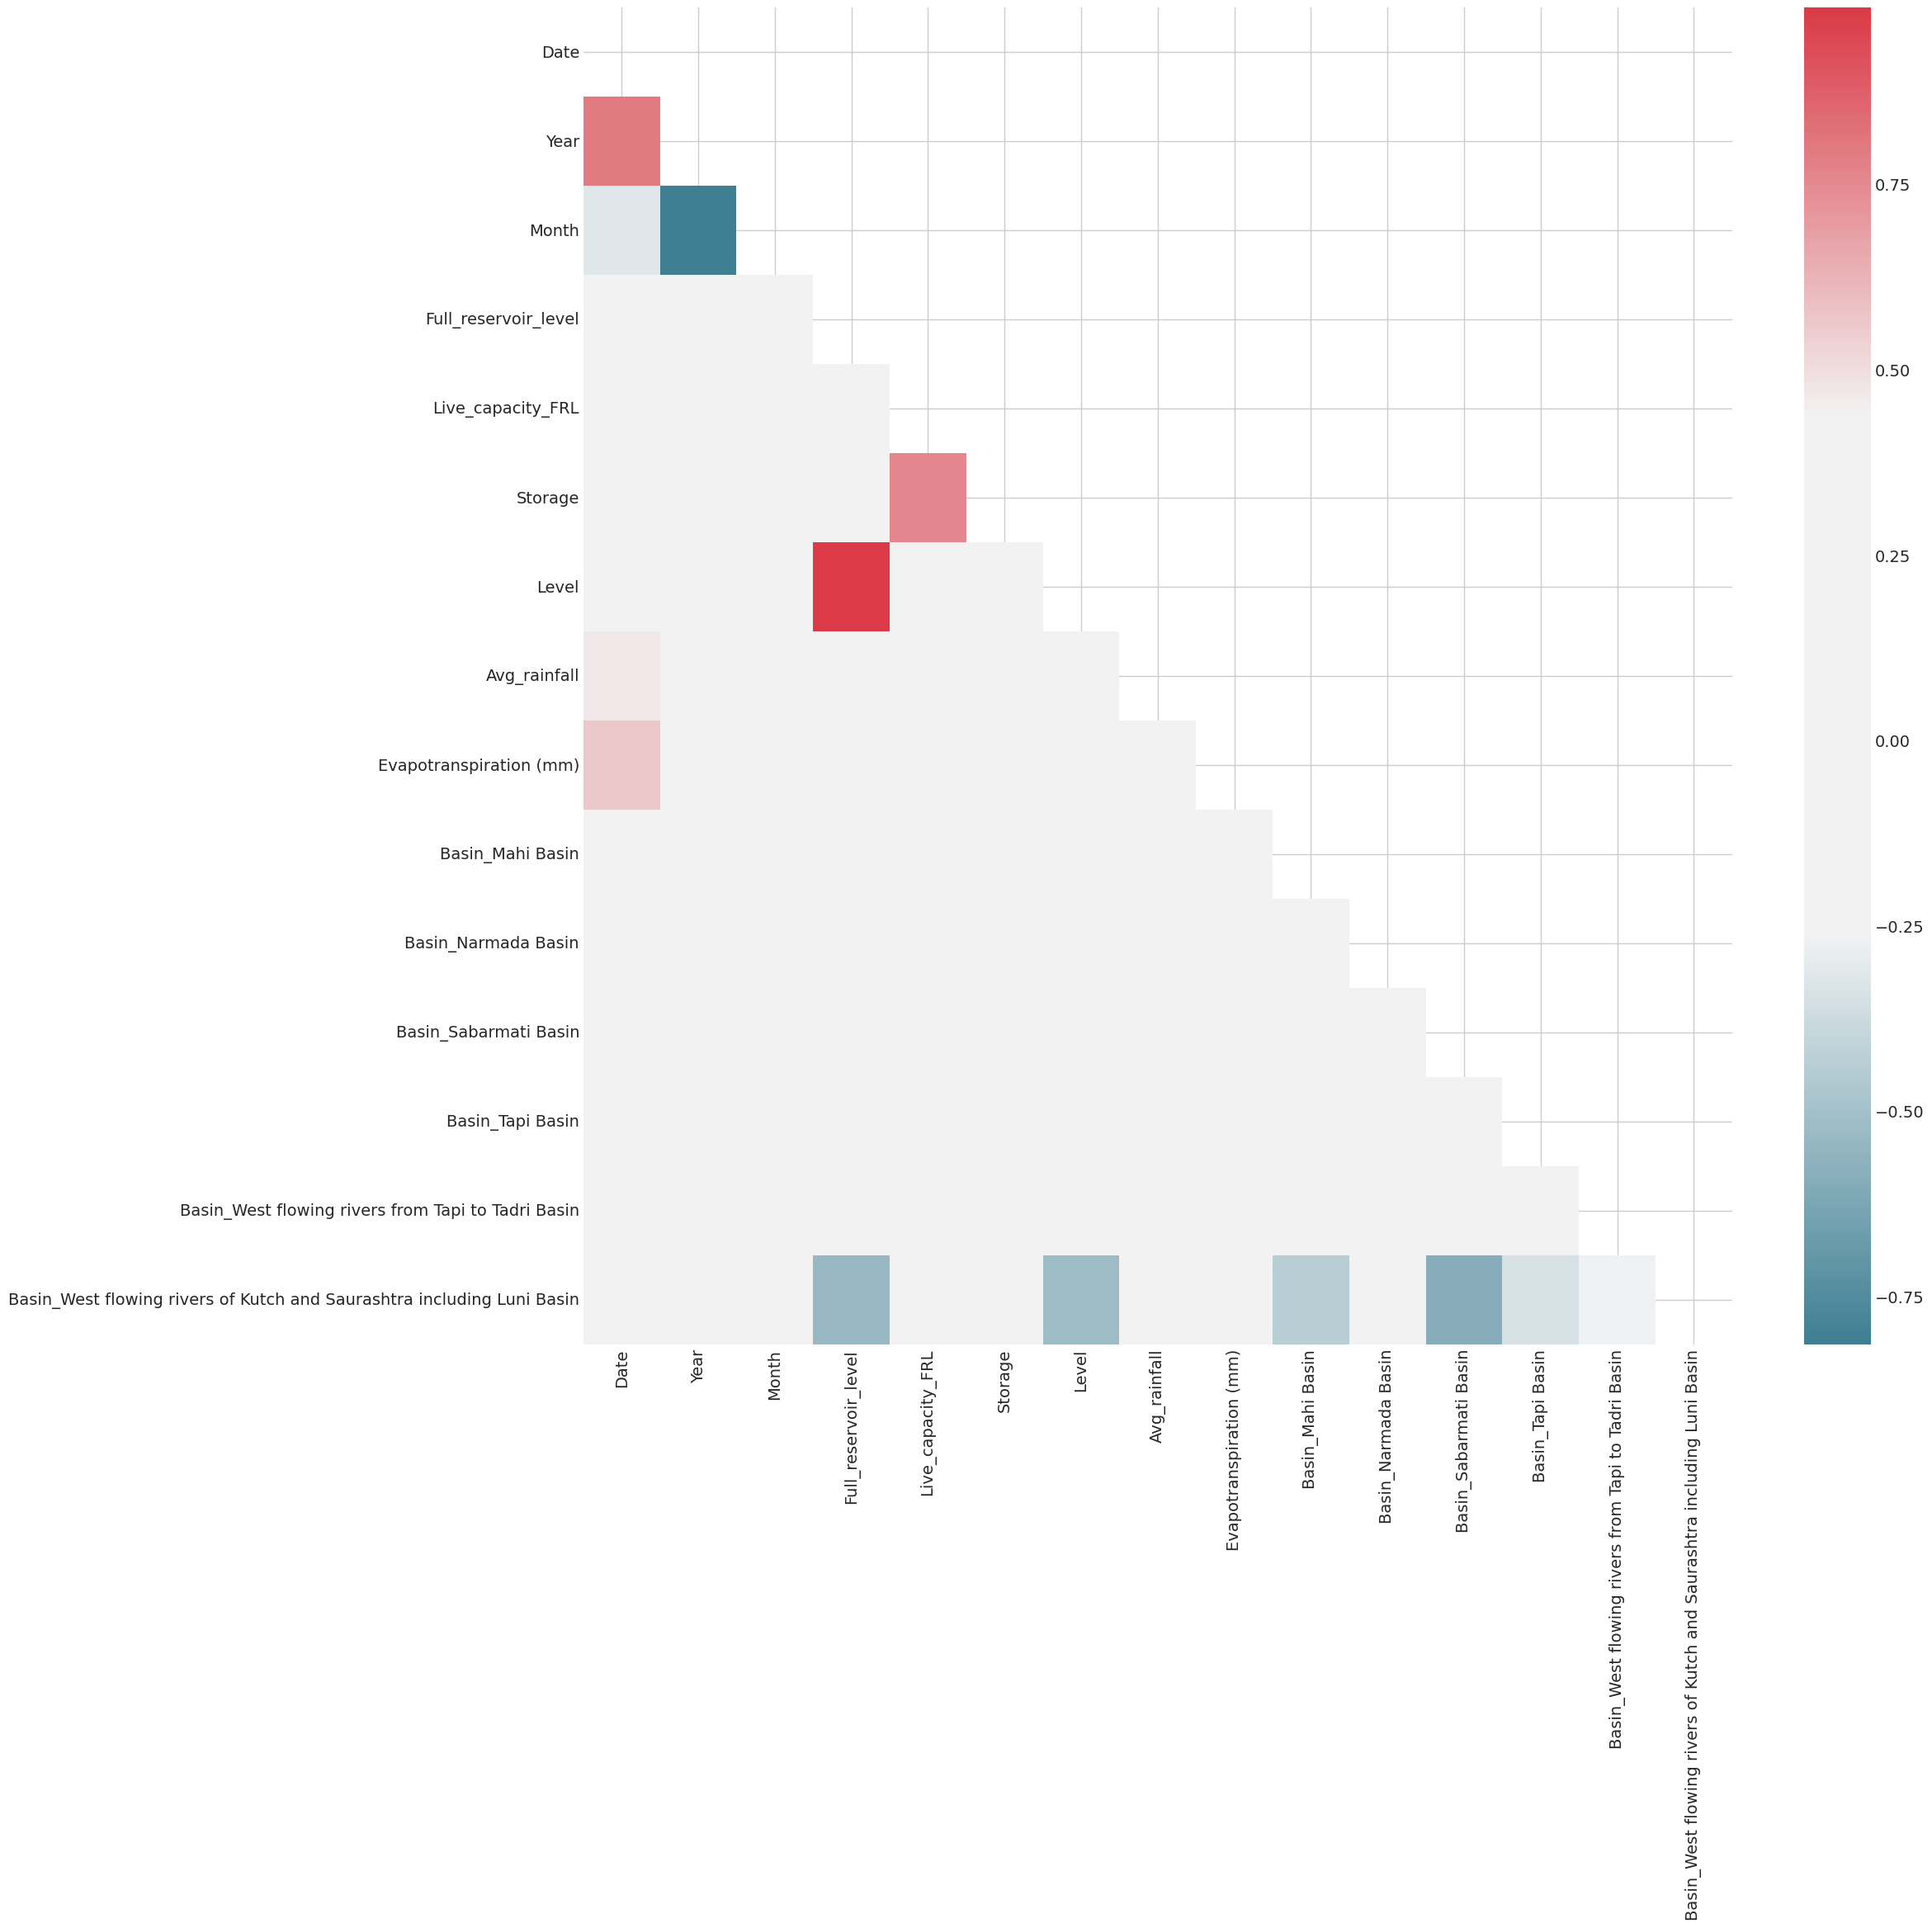

In [94]:
#MULTICOLLINEARILTY CHECK
#SPEARMAN CORRELATION BETWEEN VARIABLES
spear=mergeall.corr(method='spearman')
mask=np.zeros_like(spear,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

cmap=sns.diverging_palette(220,10,as_cmap=True,sep=100)
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(spear,mask=mask,cmap=cmap,ax=ax)

<Axes: xlabel='Full_reservoir_level', ylabel='Level'>

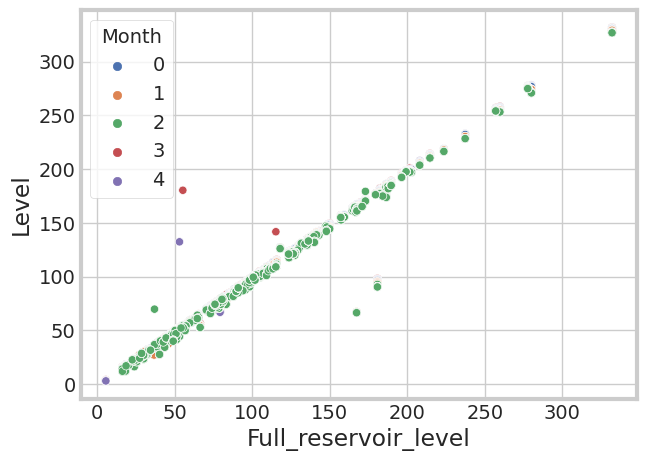

In [95]:
#Scatter plots
sns.scatterplot(data=mergeall,x='Full_reservoir_level',y='Level',hue='Month',palette='deep')

<Axes: xlabel='Evapotranspiration (mm)', ylabel='Level'>

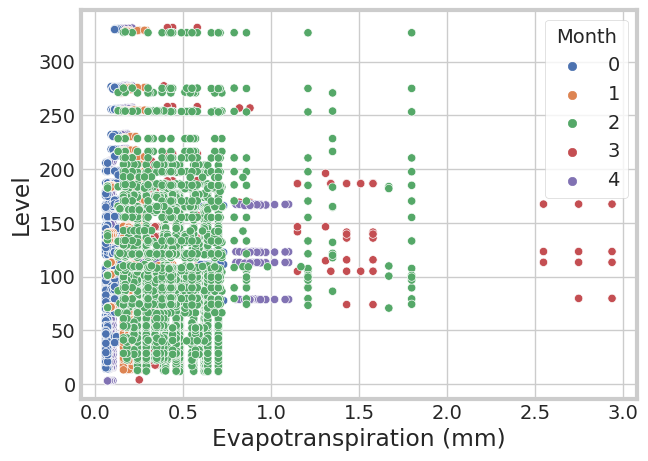

In [96]:
sns.scatterplot(data=mergeall,x='Evapotranspiration (mm)',y='Level',hue='Month',palette='deep')

# MODELLING

In [97]:
X=mergeall[['Date','Evapotranspiration (mm)','Full_reservoir_level','Basin_Mahi Basin','Basin_Narmada Basin','Basin_Sabarmati Basin','Basin_Tapi Basin','Basin_West flowing rivers from Tapi to Tadri Basin' ]]
y=mergeall[['Level']]

In [98]:
#Test and Train splitting of data
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=80)


In [99]:
#OLS Model 
mlr=LinearRegression()
mlr.fit(X_train,y_train)
mlr_yhat=mlr.predict(X_test)
print("Coefficient of mlr model:",mlr.coef_)
print("Intercept of mlr model:",mlr.intercept_)

Coefficient of mlr model: [[-0.0251785   0.38632007  0.9930932  -5.68415398 -0.03935187 -3.17142981
   0.84686568  0.58288314]]
Intercept of mlr model: [18593.26520129]


In [100]:
#LASSO REGRESSION MODEL 
lasso=Lasso(alpha=2)
lasso.fit(X_train,y_train)
lasso_yhat=lasso.predict(X_test)

# PERFORMANCE METRICS

In [101]:
#R2 Scores
mlrr2=evs(y_test,mlr_yhat)
lassor2=evs(y_test,lasso_yhat)

print("OLS model:",mlrr2)

print("Lasso model:",lassor2)

OLS model: 0.9785505167185163
Lasso model: 0.9776924070790968


In [102]:
#Explained variance score
mlrevs=evs(y_test,mlr_yhat)
lassoevs=evs(y_test,lasso_yhat)
print("OLS model:",mlrevs)
print("Lasso model:",lassoevs)

OLS model: 0.9785505167185163
Lasso model: 0.9776924070790968


# STATISTICAL TESTS

In [103]:
#F TEST
mlrols= sm.OLS(y,X).fit()
mlrols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Level   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.709e+05
Date:                Sat, 08 Apr 2023   Prob (F-statistic):                        0.00
Time:                        12:43:31   Log-Likelihood:                         -32239.
No. Observations:                8830   AIC:                                  6.449e+04
Df Residuals:                    8822   BIC:                                  6.455e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Date                                               -2.493e-06   2.89e-07     -8.635      0.000   -3.06e-06   -1.93e-06
Evapotranspiration (mm)                               -1.1237      0.429     -2.617      0.009      -1.965      -0.282
Full_reservoir_level                                   0.9929      0.002    518.745      0.000       0.989       0.997
Basin_Mahi Basin                                      -6.3800      0.415    -15.387      0.000      -7.193      -5.567
Basin_Narmada Basin                                    0.2344      0.882      0.266      0.790      -1.495       1.964
Basin_Sabarmati Basin                                 -2.7758      0.332     -8.359      0.000      -3.427      -2.125
Basin_Tapi Basin                                       0.8973      0.478      1.878      0.060      -0.039       1.834
Basin_West flowing rivers from Tapi to Tadri Basin     1.2591      0.611      2.061      0.039       0.061       2.457
==============================================================================
Omnibus:                    11584.154   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2126974.696
Skew:                          -7.467   Prob(JB):                         0.00
Kurtosis:                      77.553   Cond. No.                     6.62e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.62e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [104]:
print(mlrols.f_pvalue )
print("Because our f_pvalue is lower than 0.05 we can conclude that \n our model performs better than other simpler model.")

0.0
Because our f_pvalue is lower than 0.05 we can conclude that 
 our model performs better than other simpler model.


In [105]:
#T TEST
print(mlrols.pvalues)

Date                                                  6.879238e-18
Evapotranspiration (mm)                               8.877082e-03
Full_reservoir_level                                  0.000000e+00
Basin_Mahi Basin                                      9.589538e-53
Basin_Narmada Basin                                   7.904716e-01
Basin_Sabarmati Basin                                 7.294213e-17
Basin_Tapi Basin                                      6.038756e-02
Basin_West flowing rivers from Tapi to Tadri Basin    3.934927e-02
dtype: float64


In [106]:
#RESIDUAL ANALYSIS
analysis=X

analysis['pred_values']=mlrols.predict(X)
analysis['actual_values']=mergeall['Level']
analysis['Residuals']=mlrols.resid
analysis.head(5)

<ipython-input-106-1efefd16c50c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis['pred_values']=mlrols.predict(X)
<ipython-input-106-1efefd16c50c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis['actual_values']=mergeall['Level']
<ipython-input-106-1efefd16c50c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Date,Evapotranspiration (mm),Full_reservoir_level,Basin_Mahi Basin,Basin_Narmada Basin,Basin_Sabarmati Basin,Basin_Tapi Basin,Basin_West flowing rivers from Tapi to Tadri Basin,pred_values,actual_values,Residuals
0,738469,0.25,24.00,0,0,0,0,0,21.706871,22.30,0.593129
1,738469,0.25,182.31,0,0,0,0,0,178.888860,182.20,3.311140
2,738469,0.25,5.64,0,0,0,0,0,3.477692,4.07,0.592308
3,738469,0.25,16.25,0,0,0,0,0,14.012092,16.06,2.047908
4,738469,0.25,53.10,0,0,0,0,0,50.599524,53.10,2.500476


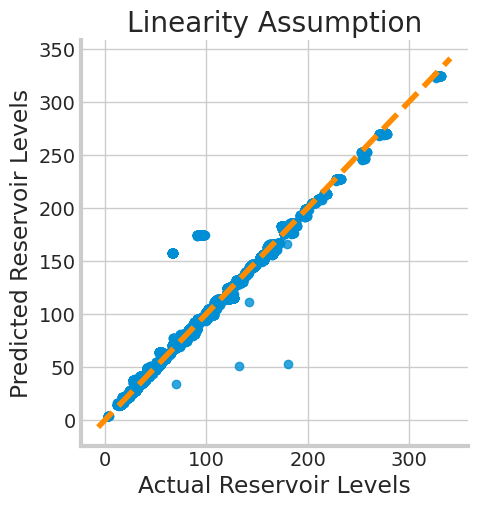

In [107]:
#LINEARITY

# Plotting the observed vs predicted values
sns.lmplot(x='actual_values', y='pred_values', data=analysis, fit_reg=False)
    
# Plotting the diagonal line
line_coords = np.arange(analysis[['actual_values', 'pred_values']].min().min()-10, 
                        analysis[['actual_values', 'pred_values']].max().max()+10)
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')

plt.ylabel('Predicted Reservoir Levels')
plt.xlabel('Actual Reservoir Levels')
plt.title('Linearity Assumption')
plt.show()

#The scatter plots show residual point evenly spread around the diagonal line, 
#so we can assume that there is linear relationship between our independent and dependent variables.

<ipython-input-108-56fa9e817fe4>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(analysis['Residuals'])


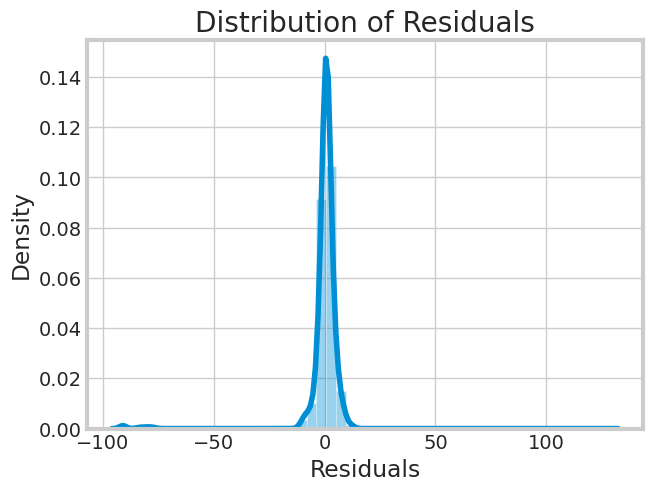

In [108]:
#NORMALITY 

# Plotting the residuals distribution

plt.title('Distribution of Residuals')
sns.distplot(analysis['Residuals'])
plt.show()

#residuals look normally distributed


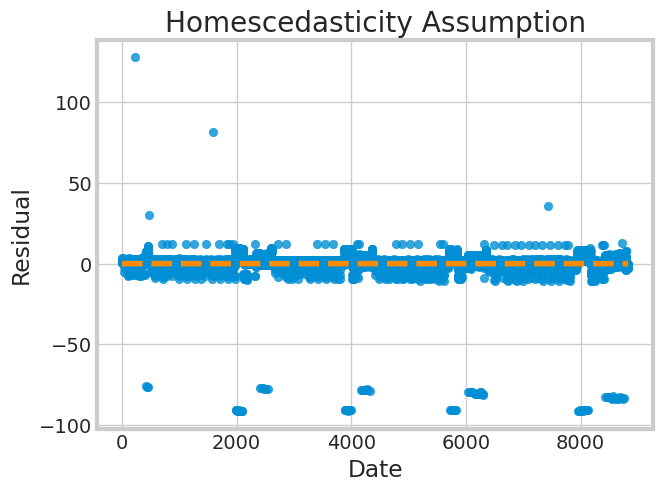

In [109]:
#HOMOSCEDASTICITY

# Plotting the residuals

plt.scatter(x=analysis.index, y=analysis.Residuals, alpha=0.8)
plt.plot(np.repeat(0, len(analysis.index)+2), color='darkorange', linestyle='--')

plt.ylabel('Residual')
plt.xlabel('Date')
plt.title('Homescedasticity Assumption')
plt.show()

#The residuals seems to have constant and uniform variance, so we can assume that it satisfied the homoscedasticity assumption.

# PREDICTION GUI


In [110]:
# Values to predict

dateinput = str(input('What is date (Use format YYYY-MM-DD): \n'))
evapoinput = float(input('What is the evapotranspiration rate (float): \n'))
fullinput=float(input("What is the full reservoir level(float): \n"))
Mahi=int(input("Is it Mahi basin: (1 for yes, 0 for no): \n"))
Narmada=int(input("Is it Narmada basin: (1 for yes, 0 for no): \n"))
Sabarmati=int(input("Is it Sabarmati basin: (1 for yes, 0 for no): \n"))
Tapi=int(input("Is it Tapi basin: (1 for yes, 0 for no): \n"))
West1=int(input("Is it West flowing from tapi to tadri basin: (1 for yes, 0 for no): \n"))

dateinput=pd.to_datetime(dateinput)
x_pred=np.array([dateinput.toordinal(),evapoinput,fullinput, Mahi, Narmada , Sabarmati , Tapi, West1])
x_pred=x_pred.reshape(-1,8)
levelpred=mlr.predict(x_pred)

try:
    print('We predict the following reservoir level:',levelpred)
except ValueError:
    print('Please only input either:\n- whole number e.g. 1, 4, 7\n- decimal/float number e.g. 3.8')


What is date (Use format YYYY-MM-DD): 
2023-06-06
What is the evapotranspiration rate (float): 
0.22
What is the full reservoir level(float): 
135
Is it Mahi basin: (1 for yes, 0 for no): 
0
Is it Narmada basin: (1 for yes, 0 for no): 
0
Is it Sabarmati basin: (1 for yes, 0 for no): 
0
Is it Tapi basin: (1 for yes, 0 for no): 
1
Is it West flowing from tapi to tadri basin: (1 for yes, 0 for no): 
0
We predict the following reservoir level: [[129.48429729]]


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# APPENDIX: 3D GRAPH CREATION FOR MLR


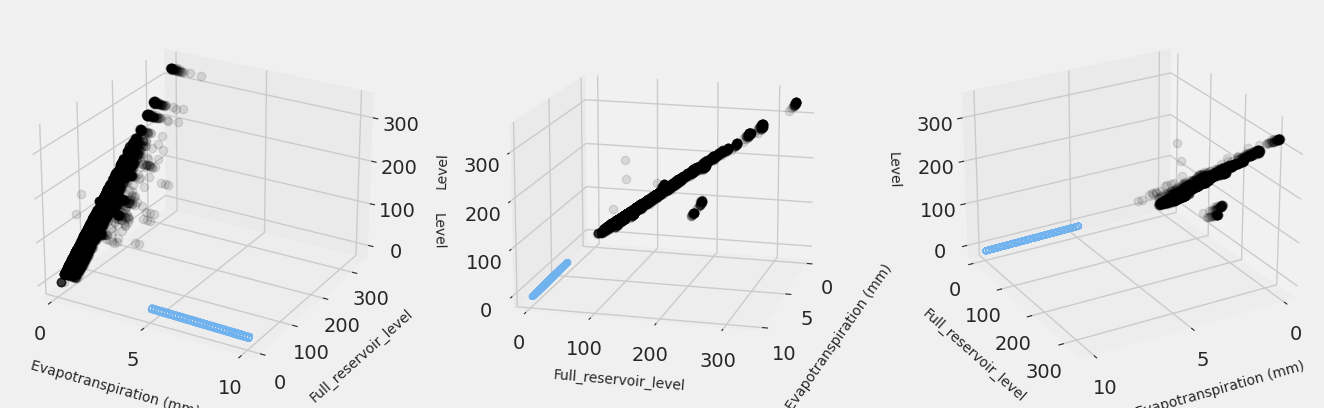

In [111]:
# Plotting a 3-D plot for visualizing the Multiple Linear Regression Model  
  
# Preparing the data  
independent = mergeall[['Evapotranspiration (mm)', 'Full_reservoir_level']].values.reshape(-1,2)  
dependent = mergeall['Level']  
  
# Creating a variable for each dimension  
xplot = independent[:, 0]  
yplot = independent[:, 1]  
zplot = dependent  
  
xplot_range = np.linspace(5, 10, 35)    
yplot_range = np.linspace(3, 6, 35)   
xplot_range, yplot_range = np.meshgrid(xplot_range, yplot_range)  
viz = np.array([xplot_range.flatten(), yplot_range.flatten()]).T  
  
# Predicting price values using the linear regression model built above 
mlr1=LinearRegression()
mlr1=mlr1.fit(independent, dependent) 
predictions = mlr1.predict(viz)  
  
  
# Ploting the model for visualization  
plt.style.use('fivethirtyeight')  
  
# Initializing a matplotlib figure  
fig = plt.figure(figsize = (15, 6))  
  
axis1 = fig.add_subplot(131, projection = '3d')  
axis2 = fig.add_subplot(132, projection = '3d')  
axis3 = fig.add_subplot(133, projection = '3d')  
  
axes = [axis1, axis2, axis3]  
  
for ax in axes:  
    ax.plot(xplot, yplot, zplot, color='k', zorder = 10, linestyle = 'none', marker = 'o', alpha = 0.1)  
    ax.scatter(xplot_range.flatten(), yplot_range.flatten(), predictions, facecolor = (0,0,0,0), s = 20, edgecolor = '#70b3f0')  
    ax.set_xlabel('Evapotranspiration (mm)', fontsize = 10, labelpad = 10)  
    ax.set_ylabel('Full_reservoir_level', fontsize = 10, labelpad = 10)  
    ax.set_zlabel('Level', fontsize = 10, labelpad = 10)  
    ax.locator_params(nbins = 3, axis = 'x')  
    ax.locator_params(nbins = 3, axis = 'x')  
  
axis1.view_init(elev=25, azim=-60)  
axis2.view_init(elev=15, azim=15)  
axis3.view_init(elev=25, azim=60)  